# Dependencies

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files, drive
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [4]:
sns.set()
drive.mount('/content/drive')

Mounted at /content/drive


#Data

In [8]:
data_path = '/content/drive/MyDrive/Studia/DS/Sem2/AML/Project2/Data'

In [13]:
X = np.loadtxt(data_path+'/x_train.txt')
y = np.loadtxt(data_path+'/y_train.txt')
test = np.loadtxt(data_path+'/x_test.txt')

# EDA

##Basic statistics

In [17]:
Xdf = pd.DataFrame(X)

In [26]:
Xdf_desc = Xdf.describe().drop("count", axis=0).T

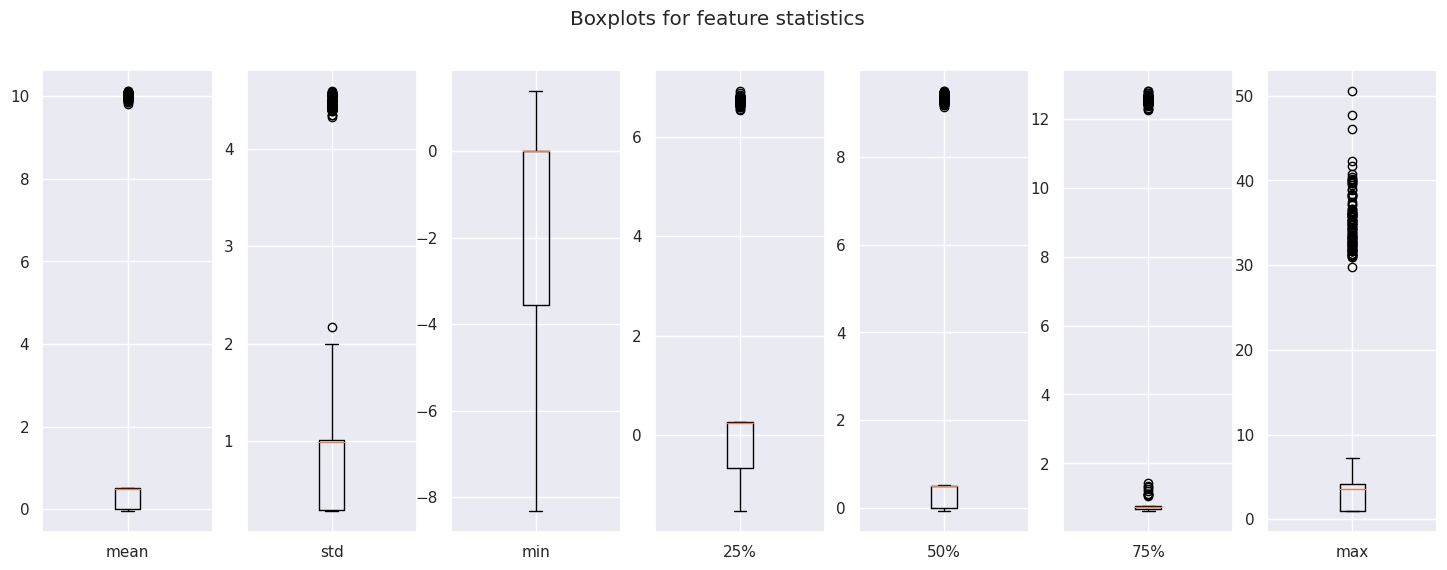

In [48]:
fig, ax = plt.subplots(1, Xdf_desc.shape[1], figsize=(18,6))
for i in range(Xdf_desc.shape[1]):
  ax[i].boxplot(Xdf_desc.iloc[:,i], labels=[Xdf_desc.columns[i]])
plt.suptitle("Boxplots for feature statistics")
plt.show()

There is 500 features so we can't really analyze statistics of them one by one so instead of that I have plotted boxplots for them. For example, first plot shows the boxplot of means of all of the features.  


My observations:


*   it seem that for every statistic there may be a similar number of outliers


In [69]:
quantiles = Xdf_desc.quantile([0.25, 0.75])
IQR = quantiles.iloc[1,:] - quantiles.iloc[0,:]
outliers_idx = []
for i in range(Xdf_desc.shape[1]):
    lower_bound = quantiles.iloc[0,i] - IQR[i] * 1.5
    upper_bound = quantiles.iloc[1,i] + IQR[i] * 1.5
    outliers = Xdf_desc.loc[(Xdf_desc.iloc[:, i] < lower_bound) | (upper_bound < Xdf_desc.iloc[:, i]), :]
    outliers_idx += list(outliers.index)
    print(f"Number of outliers for {Xdf_desc.columns[i]}: {outliers.shape[0]}")

Number of outliers for mean: 100
Number of outliers for std: 101
Number of outliers for min: 0
Number of outliers for 25%: 100
Number of outliers for 50%: 100
Number of outliers for 75%: 110
Number of outliers for max: 100


In [185]:
print("These features are outliers in terms of all of the statistics besides min.\n")
display(pd.Series(outliers_idx).value_counts()[pd.Series(outliers_idx).value_counts() == 6].sort_index())
print("\nThey are the last 100 features.")

These features are outliers in terms of all of the statistics besides min.



400    6
401    6
402    6
403    6
404    6
      ..
495    6
496    6
497    6
498    6
499    6
Name: count, Length: 100, dtype: int64


They are the last 100 features.


In [187]:
Xdf.iloc[:10, 399:]

,399,400,401,402,403,404,405,406,407,408,...,490,491,492,493,494,495,496,497,498,499
0,0.042758,8.672788,18.255863,5.275750,6.703744,6.920014,10.103512,11.440402,12.265522,3.651574,...,10.849925,10.343346,10.717519,7.709295,5.894554,12.416573,6.765269,16.243907,7.209524,8.082021
1,0.326739,6.445116,10.227052,6.363166,22.892464,3.869980,14.831150,3.730106,5.652568,6.432817,...,11.489417,5.195818,3.494627,5.529154,10.517576,15.697333,11.324938,12.187670,12.283861,5.032285
2,0.760531,4.400282,7.399125,19.745787,9.485307,16.252857,7.793485,3.539180,8.193167,13.334514,...,13.934934,9.267515,4.705604,6.642557,14.658934,8.130767,7.194487,11.939354,11.653620,5.942778
3,0.774971,14.943798,4.749226,7.793544,13.560110,7.725283,7.049717,11.078125,8.080817,6.594378,...,12.021328,3.852231,11.059702,7.527268,7.253120,9.791136,6.089743,10.752796,5.778888,10.366363
4,0.877318,9.480239,4.974829,20.958659,32.448657,15.217896,6.335503,9.371874,15.982874,4.970122,...,7.537788,11.229665,11.318915,6.622256,12.557882,5.520360,5.397359,13.152269,10.684779,9.816471
5,0.755884,10.743551,10.065669,5.520040,14.714617,5.120736,8.977502,14.795851,17.878376,10.717589,...,8.289674,6.093594,4.416658,15.211637,11.192712,6.078597,9.310094,21.242321,9.609416,13.421308
6,0.143116,11.834880,13.626940,9.876723,11.020256,8.180340,11.900787,7.988021,3.531931,10.470599,...,10.219742,10.470164,5.902090,6.205519,18.048176,16.583878,2.825749,6.587279,10.553341,7.390611
7,0.769076,12.673956,4.199337,18.974788,12.333274,11.805384,3.162654,7.885570,6.454116,17.633936,...,6.198733,10.961812,6.164077,16.374236,9.904298,11.700650,5.394502,10.794663,15.755809,7.541037
8,0.943848,14.964952,11.279138,15.787655,4.514447,11.720678,8.328825,10.949849,12.895558,9.661484,...,11.483434,5.057031,9.452941,14.936409,7.430070,6.211091,6.680447,6.133520,6.179452,9.365081
9,0.781064,18.237626,11.423784,13.873736,7.514361,8.636408,8.062090,2.410845,4.958841,11.697878,...,17.508238,11.901790,14.256177,11.632499,8.853583,6.275898,4.942811,16.971388,5.540426,9.788944


Last 100 features are of a different order of magnitude.

##Target ditribution.

In [90]:
print("Fraction of clients that accepted the offer:", np.mean(y))

Fraction of clients that accepted the offer: 0.4992


##Correlation

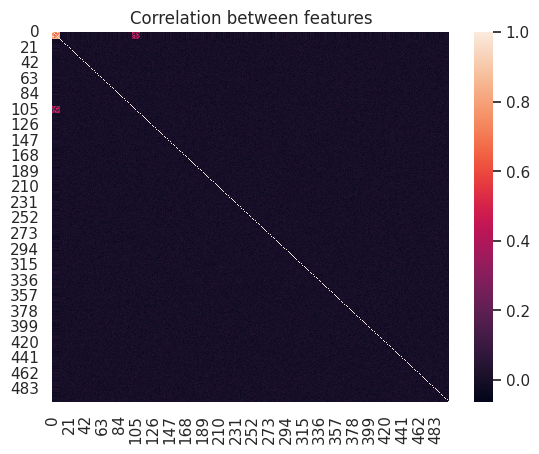

In [116]:
sns.heatmap(Xdf.corr())
plt.title("Correlation between features")
plt.show()

Let's zoom in on those patches that are more correlated.

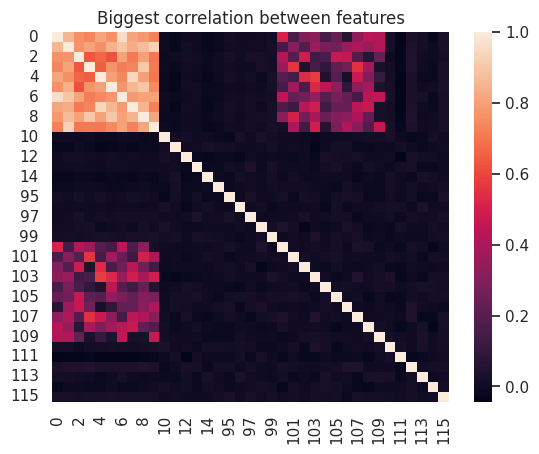

In [117]:
sns.heatmap(Xdf.iloc[:,[i for i in range(16)]+[i for i in range(95, 116)]].corr())
plt.title("Biggest correlation between features")
plt.show()

In [178]:
Xdf.iloc[:10,[i for i in range(10)]+[i for i in range(100, 110)]] # those correlated features for couple of rows

,0,1,2,3,4,5,6,7,8,9,100,101,102,103,104,105,106,107,108,109
0,-2.619773,-2.619533,-1.199350,-1.083335,-1.000910,-0.366967,-2.164037,-1.210001,-0.658311,-1.489539,-0.915513,0.713780,0.264032,-0.177042,-0.123621,1.049388,-0.715826,-0.997405,-0.553252,-1.646694
1,-1.415579,-1.782544,-2.880270,-1.958863,1.159968,0.273030,-1.628728,-0.175813,-0.916857,-0.570166,-1.513469,0.506429,1.071525,1.823868,0.083758,-1.191206,-2.039583,-0.442612,-0.723200,-0.266971
2,-2.745092,-1.382945,-1.626015,-1.282560,-0.663146,0.052349,-2.403322,-0.765073,-0.394354,-0.806624,-1.215839,-0.112797,-0.162820,0.771938,1.255190,-0.626576,0.269367,0.130045,-1.396269,-1.237523
3,0.618998,0.455364,-0.115081,0.649040,-0.862207,2.308504,0.526114,-1.094852,1.088656,-0.481210,1.167745,0.777688,-1.572364,0.211630,3.029617,0.861478,-1.415890,-0.059401,-1.001149,-0.182232
4,-0.070694,-0.550509,-0.565556,-0.693065,-0.573089,-0.395862,0.003170,-0.981609,-0.505775,-0.758430,0.219875,0.579971,0.702204,-0.455936,0.993229,-1.422561,-0.478544,-0.823916,-0.112448,0.488651
5,-0.874568,-0.827797,-0.529402,0.294422,1.571518,1.535509,-1.022122,1.663973,1.364033,-0.546665,0.143187,0.222185,0.473609,1.846459,0.583639,-0.859492,0.009056,0.313506,-0.550269,-2.464323
6,-3.578858,-2.682620,-2.051490,-1.168331,-2.704543,-1.396279,-2.671012,-2.154212,-1.502912,-1.659694,-1.094154,0.080384,-1.051216,-0.744677,-0.182602,0.574484,0.609945,-0.979928,-0.005482,-1.501569
7,1.104724,-0.353812,-0.062637,0.947683,0.053637,-0.201497,0.093941,-0.331237,0.048325,-1.428255,1.137886,0.502304,0.659511,-1.658020,0.718173,-0.787428,-1.304181,0.940511,0.245240,0.055308
8,-0.673088,0.622693,-0.708925,-0.528495,-0.756041,-0.135501,0.025696,-0.897472,-0.425012,1.402470,-1.083088,0.360868,-0.988246,0.678766,-0.412990,0.380289,0.365971,-0.557755,-0.283990,1.100018
9,-3.381725,-2.280436,-1.953287,-1.185672,-4.186837,-3.296789,-2.904234,-4.323203,-2.094594,-1.555376,0.318413,-0.426274,-2.073879,-1.431916,0.361997,-1.334603,1.598179,0.360213,-1.937769,0.167245


In [104]:
Xydf = pd.concat([Xdf, pd.Series(y)], axis=1)

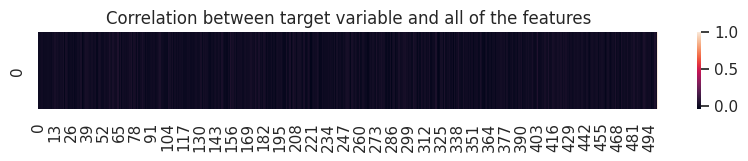

In [115]:
correlation = Xydf.corrwith(pd.Series(y))

# Convert the Series to a DataFrame and transpose it for the heatmap
correlation_df = pd.DataFrame(correlation).T

# Plot the heatmap
plt.figure(figsize=(10, 1))  # Adjust size as needed
sns.heatmap(correlation_df)
plt.title("Correlation between target variable and all of the features")
plt.show()

# Basic models

In [120]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.3)

In [173]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

In [174]:
knn = KNeighborsClassifier()
logreg2 = LogisticRegression(max_iter=100000)
logreg1 = LogisticRegression(penalty="l1", max_iter=100000, solver="liblinear")
nb = GaussianNB()
forest = RandomForestClassifier()
classifiers = {"knn": knn, "logreg1": logreg1, "logreg2": logreg2, "nb": nb, "forest": forest}

In [175]:
for key,value in classifiers.items():
  value.fit(Xtrain_scaled, ytrain)
  print(f"{key} accuracy: {value.score(Xtest_scaled, ytest)}")

knn accuracy: 0.4886666666666667
logreg1 accuracy: 0.5066666666666667
logreg2 accuracy: 0.508
nb accuracy: 0.6033333333333334
forest accuracy: 0.582


#Key notes


*   Target variable is balanced.
*   Features from 400 to 499 have bigger values then the rest.
*   Features from 1 to 10 are highly correlated.
*   Features from 100 to 110 are a little bit correlated to those from 1 to 10.
*   Simple models build on all of the features don't really work.
*   Naive bayes had the best accuracy - 60%. Maybe assuming independence between variables has some merit to it.
